In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv("SSBCI_data.csv")
df.drop(['state_id','full_time_employees', 'Unnamed: 0','borrower_insurance_premium',
         'lender_insurance_premium','jobs_created','job_benefit'], axis=1, inplace=True)
df.head()

,program_type,loan_investment_amount,ssbci_original_funds,nonprivate_amount,concurrent_private_financing,guaranteed_amount,collateral_support,ssbci_recycled_funds,subsequent_private_financing,metro_type,LMI_type,revenue,naics_code,year_incorporated,jobs_retained,trans_type,CDFI_type,SPY_Close,U_Rate,creation_status
0,4,180000.0,90000.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.0,681,103,1.0,1,2,152.110001,7.5,1.0
1,4,2400000.0,250000.0,0.0,0.0,0.0,0.0,0.0,1520000.0,0,0,0.0,439,102,0.0,1,2,167.509995,7.3,1.0
2,4,265000.0,110000.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.0,681,103,5.0,1,2,183.820007,6.7,1.0
3,4,199500.0,99750.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.0,378,104,0.0,1,2,181.509995,6.2,1.0
4,4,125000.0,62500.0,0.0,125000.0,0.0,0.0,0.0,0.0,0,0,1494916.0,519,97,0.0,1,2,187.399994,6.3,1.0


In [6]:
X = df.copy()
X.drop("creation_status", inplace = True, axis = 1)
Y = df.creation_status

In [7]:
#X_train, X_test = X[:int(X.shape[0]*0.8)].values, X[int(X.shape[0]*0.8):].values
#Y_train, Y_test = Y[:int(X.shape[0]*0.8)].values, Y[int(X.shape[0]*0.8):].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
test_size=0.33, random_state=42)


In [8]:
train = xgb.DMatrix(X_train, label = Y_train)
test = xgb.DMatrix(X_test, label = Y_test)

AttributeError: 'DMatrix' object has no attribute 'print'

In [9]:
param = {'max_depth' : 20, 'eta' : 0.3, 'verbosity' : 0, 'objective' : 'binary:hinge', 
         'eval_metric': 'aucpr', 'predictor':'gpu_predictor'}
num_rounds = 5
model = xgb.train(param, train, num_rounds)

In [10]:
preds = model.predict(test)

In [11]:
import pickle
pickle.dump(model, open("model.dat", "wb"))

model.save_model("model.json")

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, f1_score, recall_score

print('Confusion matrix')
print(confusion_matrix(Y_test, preds))
acc = accuracy_score(Y_test, preds)
print(f'Accuracy: {acc: .2%}')
pr = precision_score(Y_test, preds)
print(f'Precision: {pr: .2%}')
re = recall_score(Y_test, preds)
print(f'Recall score: {re: .2%}')
f1 = f1_score(Y_test, preds)
print(f'F1 score: {f1: .2%}')

Confusion matrix
[[2934 1227]
 [ 822 2265]]
Accuracy:  71.73%
Precision:  64.86%
Recall score:  73.37%
F1 score:  68.86%


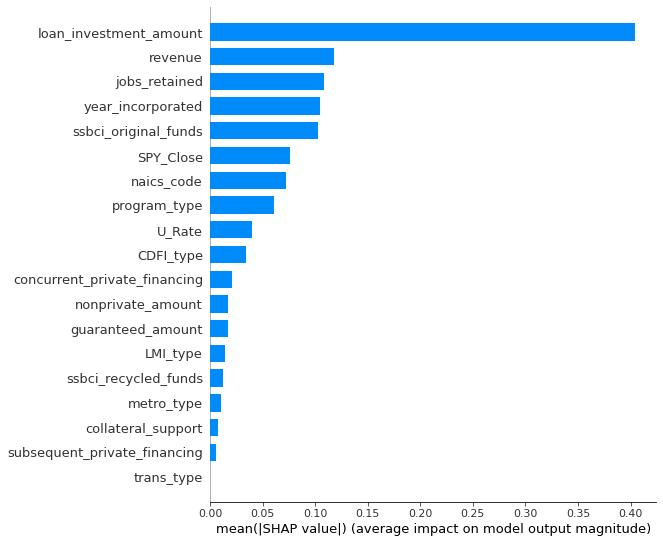

In [13]:
import shap

explainer_km = shap.TreeExplainer(model)
shap_values_km = explainer_km.shap_values(X)
shap.summary_plot(shap_values_km, X, plot_type="bar")

In [14]:
import joblib
joblib.dump(model, 'model.pkl')
print("Model dumped!")

Model dumped!


In [16]:
# Load the model that you just saved
model = joblib.load('model.pkl')

# Saving the data columns from training
model_columns = list(X.columns)
joblib.dump(model_columns, 'model_columns.pkl')
print("Models columns dumped!")


Models columns dumped!
